# Data Mining for Security Applications: final project

This final hands on project will count for 50% of your final grade (exam is the other 50%)

## Organization
* you can start the project as of now
* the project has to be handed in no later than March 1st - NO EXTENSIONS!

### Project Submission 
* hand in a single jupyter notebook for your project (via moodle)
* set all paths as relative paths such that the data is in the same folder as the notebook
* your notebook should run without errors (uncomment parts that do not work)
* Use markdown cells and comments in the code to document and motivate you solution
* show and analyze intermediate results
* evaluate and discuss your solution

### Grading Criteria
* 4.0 : notebook that works and gives some solution to the problem
* 3.0 : + good documentation, evaluation and discussion
* 2.0 : + complete processing pipeline, good results
* 1.0 : + very detailed documentation and analysis, hyper-parameter optimization, tried and compared more than one method 



# Task: Breaking image captchas  

We are working on this Kaggle Challenge: https://www.kaggle.com/fournierp/captcha-version-2-images  

HINT: have a good look at the problem description and the notebooks of other users to get started 

* Train and test images are in the according folders
* The true labels are encoded in the file names 

## Tasks to follow:
* write code to read the images [use the imageio lib](https://imageio.readthedocs.io/en/stable/userapi.html) and convert then into NUMPY feature vectors
and labels
    * HINT: use [the os lib](https://docs.python.org/2/library/os.html#os.listdir) to get files in a directory
* the hardest part is to solve the segmentation problem: splitting the image into single characters
    * try Clustering over pixel positions
    * or a density projection along the y-axis
* crate a training data set of labeled character segments
    * evaluate this step
* train a CNN or MLP network to classify character segments
    * evaluate this step
* build a full pipeline to transform capcha image inputs into strings
* Evaluate and discuss your results

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

np.random.seed(2)

from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Layer, Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation#, Reshape, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

I prepare the paths to the training and test data and check the amount of captchas I have in training and testing aswell as the name of the the data.

In [2]:
# path to the directory train
train_dir = Path("./train/")
# get all images from train
train_images = list(train_dir.glob("*.png"))
print("Number of images found: ", len(train_images))
print(train_images[0]) 

Number of images found:  942
train\226md.png


In [3]:
# path to the directory test
test_dir = Path("./test/")
# get all images from test
test_images = list(test_dir.glob("*.png"))
print("Number of images found: ", len(test_images))
print(test_images[0]) 

Number of images found:  98
test\2g783.png


## Loading images

In this step I was looking at the captchas themself and their shape.

Shape of image:  (50, 200, 3)


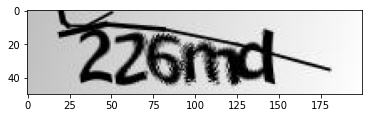

In [4]:
# test if I can read a image and plot one
img = cv2.imread(str(train_images[0]))
# look at the shape of the image
print("Shape of image: ", img.shape)
# show the image
plt.imshow(img)

Shape of image:  (50, 200, 3)


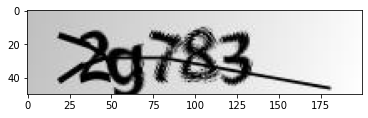

In [5]:
#same as above just with the test data
img = cv2.imread(str(test_images[0]))
# look at the shape of the image
print("Shape of image: ", img.shape)
# show the image
plt.imshow(img)

### Define padding function

The padding function will later be used to change the dimensions of the characters we will isolate to achieve the required dimensions.

In [6]:
kernel =np.ones((3,1),np.uint8)
borderType = cv2.BORDER_CONSTANT
def pad(src): 
    top = int(0.05 * src.shape[0])  # shape[0] = rows
    bottom = top
    left = int(0.15 * src.shape[1])  # shape[1] = columns
    right = left
    des=cv2.copyMakeBorder(src, top, bottom, left+1, right, borderType, None,255)
    return cv2.bitwise_not(des)


### Create labeled Data

In this step I removed the line as best as I could by using a combination of treshholding and dilating. After that I hardcoded the position of each letter. This is possible because all letters are at the same position. The hardcoded positions alllow to sepearate each character and assign it the corresponding label. The padding function fills the edges of the character. Now we have labeled data in a list. 

In [7]:
X_orig=[]
y_orig=[]

for image in train_images:
    im=cv2.imread(str(image),0) # load the image
    # use threshold and dilate to get rid of the line that crosses through the characters
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5): # append the characters to the list X_orig and the labels to y_orig
        X_orig.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y_orig.append(s[-9+i])

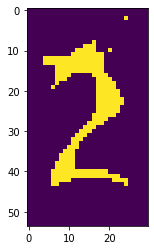

In [8]:
# this is a example of an isolated character 
plt.imshow(X_orig[0])

In [9]:
# This is the corresponding label to the character above
y_orig[0]

'2'

### Show frequencies of the characters

This looks at the frequency of each character to decide if the data is biased.

In [10]:
y_train=np.array(y_orig)

In [11]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[['2' '241']
 ['3' '237']
 ['4' '259']
 ['5' '263']
 ['6' '241']
 ['7' '232']
 ['8' '246']
 ['b' '212']
 ['c' '238']
 ['d' '234']
 ['e' '209']
 ['f' '242']
 ['g' '236']
 ['m' '240']
 ['n' '482']
 ['p' '229']
 ['w' '211']
 ['x' '246']
 ['y' '212']]


Little imbalance with the character n, but I decided to ignore this imbalance.

### Data Preparation / splitting Data

In [12]:
#Found this and I got better results when using it
def apply_abi(image, label, layer_length):
    new_images = []
    new_labels = []
    for i in range(0, len(label)):
        binary_layer = np.zeros((image.shape[0], layer_length*len(label)))
        binary_layer[:,i*layer_length:(i+1)*layer_length] = 255
        image_copy = np.concatenate((binary_layer, image), axis=1)
        new_images.append(image_copy)
        new_labels.append(label[i])
    return new_images, new_labels

In [13]:
X_train = []

#convert the list to a np.array
X_train = np.array(X_orig) #/ 255.0
#y_train = np.array(y_orig)

print(X_train.shape)

# reshape it for later use
X_train = np.reshape(X_train,(-1,54,30,1))

(4710, 54, 30)


In [14]:
# encode the label
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_train = to_categorical(y_train)

In [15]:
# use train_test_split to get some samples for the training of the CNN
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 2)

## Defining architecture of the model

In [16]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = X_train.shape[1:]))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(19, activation = "softmax"))

In [17]:
# visualize the architecture of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 30, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 30, 16)        6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 15, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 15, 32)        12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 15, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 7, 32)         0

### Model compilation

In [18]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# reduces learning rate if model doesn´t improve
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

### Data Augmentation

Generate batches of tensor image data 

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        brightness_range=None, # no brightness shift
        shear_range=0.0, # sets shear intensity to 0
        channel_shift_range=0.0, # no random channel shifts
        fill_mode="nearest", # is the default mode
        rescale=None, # no rescaling
        validation_split=0.0, # nothing is reserved for validation
        dtype=None) # no special dtype for the generated arrays


datagen.fit(X_train)

### Fitting data into the model

This step uses the data samples and fits them into the model

In [20]:
epochs = 50 # 30 / 40 / 50
batch_size = 64 # 32 /64 / 86
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs =  50, 
                              validation_data = (X_val,y_val),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/40
58/58 [==============================] - 32s 559ms/step - loss: 3.4537 - accuracy: 0.0921 - val_loss: 2.5258 - val_accuracy: 0.1847
Epoch 2/40
58/58 [==============================] - 31s 539ms/step - loss: 2.5156 - accuracy: 0.2065 - val_loss: 1.6097 - val_accuracy: 0.5860
Epoch 3/40
58/58 [==============================] - 30s 522ms/step - loss: 1.8169 - accuracy: 0.4465 - val_loss: 0.7715 - val_accuracy: 0.7877
Epoch 4/40
58/58 [==============================] - 30s 518ms/step - loss: 1.3322 - accuracy: 0.5980 - val_loss: 0.5682 - val_accuracy: 0.8195
Epoch 5/40
58/58 [==============================] - 28s 475ms/step - loss: 1.0492 - accuracy: 0.6763 - val_loss: 0.4250 - val_accuracy: 0.8800
Epoch 6/40
58/58 [==============================] - 27s 462ms/step - loss: 0.8462 - accuracy: 0.7427 - val_loss: 0.3928 - val_accuracy: 0.8907
Epoch 7/40
58/58 [==============================] - 27s 460ms/step - loss: 0.6805 - accuracy: 0.7894 - val_loss: 0.3209 - val_accuracy: 0.9034

### Analyse losses

This shows the development of the loss and the accuracy over the different epochs

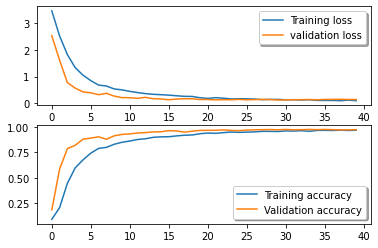

In [21]:
fig, ax = plt.subplots(2,1)
# show the development of the losses 
ax[0].plot(history.history['loss'], label="Training loss")
ax[0].plot(history.history['val_loss'], label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

#show the development of the accuracy
ax[1].plot(history.history['accuracy'], label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Analyse on Captcha images / Build Pipeline CNN

In [22]:
def predict_captcha(img,p):
    # preprocessing
    im=cv2.imread(str(img),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    images=[]
    for i in range(5):
        images.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
    images=np.reshape(images,(-1,54,30,1))
    images = np.array(images)
    # predict the model
    pred=model.predict(images)
    pred=np.argmax(pred,axis = 1)
    # reverse the label encoder
    pred = encoder.inverse_transform(pred)
    # convert the list to a string so a can compare it later
    pred = "".join(pred)
    
    # compare the string with name of the image without the directory and the .png  (thats the same as the label). 
    # if they are the same return a 1. Otherwise return a 0
    if(pred==img[-9:-4]):
        return 1
    return 0

### Accuracy

In [23]:
# get all images from the test directory
images = list(test_dir.glob("*.png"))
# counter counts all correct predictions 
correct_prediction=0
# test all images from the test directory 
for i in images:
    correct_prediction+=predict_captcha(str(i),False)

In [24]:
print("total images: ",len(images)) # number of images tested
print("correctly identified: ",correct_prediction) # number of correct predictions
print("Accuracy is: ",correct_prediction/len(images)) # ratio correct predictions to tested images

total images:  98
correctly identified:  81
Accuracy is:  0.826530612244898


### Result

I achieved an accuracy of 0.84. You could say that my model can predict 4 out of 5 captchas.  
One problem with my approach ist that if the characters are at other positions the preprocessing will deliver worse results because I hardcoded the positions of the characters.  
Another thing that isn´t optimal is the hyperparameter optimization. I completely dropped it after I realized that it ran for over 8 hours and I didn´t have a result. After this I decided to use Trial and Error to optimize some of the hyperparameters. With more computing power Randomized Search or Grid Search would be possible.

## Train a Random Forest

I decided to train a Random Forest to compare the results of the CNN. I decided to use the Random Forest because the Random Forest achieved always good results during the weekly lab and I was curious if the Random Forest will have some good results. 

### Data Preparation

I decided to create a new training set for the RFC. To do this I decided to first label the data from the training folder. After labeling the training data I converted the data into a np.array and reshaped this array. The goal of reshaping the array was to have only two dimensions because the Random Forest doesn't accept more than two dimensions. In the end I selected a random sample for the training.

In [25]:
X_train=[]
y_train=[]

# label the data

for image in train_images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        X_train.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y_train.append(s[-9+i])

#convert into np.array
X_train = np.array(X_train)
y_train = np.array(y_train)

#reshape the array to use it in the Random Forest
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))

# To finish the preparation of the training data I used train_test_split to select a random training sample
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 2)


In this step I labeled the data I later use for the evaluation of the Random Forest. The first set is the training data set and the second set is the test data set.

In [26]:
X_orig=[]
y_orig=[]

# labeling the training data

for image in train_images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        X_orig.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y_orig.append(s[-9+i])

In [27]:
X_test=[]
y_test=[]

# labeling the test data

for image in test_images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        X_test.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y_test.append(s[-9+i])

### Train the Random Forest Classifier

I trained the Random Forest with Randomized Search and used the best parameters. I didn't use any further hyperparameter optimization.

In [28]:
random_grid = {"bootstrap": [True, False],
               "criterion":["gini", "entropy"],
               "max_depth": [10, 25, 50, 75, None],
               "max_features": ["auto", "sqrt", "log2"],
               "min_samples_leaf": [1,2,4],
               "min_samples_split": [2,5,10],
               "n_estimators": [100, 250, 500]}

rfc = RandomForestClassifier()
rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid, n_iter=50, cv=5, random_state=0, n_jobs=4) # Random Search to optimize hyperparameters
rfc_random.fit(X_train, y_train)

rfc_random.best_params_ 

{'n_estimators': 250,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 75,
 'criterion': 'entropy',
 'bootstrap': False}

### Processing Pipeline Random Forest

The processing pipeline accepts the labeled data and returns a 1 if the Random Forest predicted the correct answer and a 0 if the answer was wrong.

In [29]:
def make_prediction_rfc(image, label):
    image_new = np.array(image) # image to np.array
    image_new = np.reshape(image_new, image_new.shape + (1,)) #don´t touch, don´t know why but it only works with this
    image_new = image_new.reshape((image_new.shape[2], image_new.shape[0] * image_new.shape[1])) # reshape it for the model
    pred = rfc_random.predict(image_new) # predict image
    pred = "".join(pred) # list to string

    if(pred == label): #compare image to label
        return 1
    return 0

### Evaluation Random Forest

I used the labeled data from above to to evaluate the Random Forest. To achieve this I used the processing pipeline from above aswell as the labeled training / test data. To measure the correct predictions I used a counter that added the value the pipeline returned to itself.

In [30]:
# evaluate training set
correct_pred = 0 # correct captchas
round_pred = 0 # counts the correct predictions -> gets reset after one captcha
round_counter = 0 # counts the rounds -> gets reset after five rounds (that's the lenghth of one captcha)
for image, label in zip(X_orig, y_orig):
    round_counter += 1 
    round_pred += make_prediction_rfc(image, label) # use processing pipeline with the labeled data
    if(round_counter == 5): # after 5 rounds (one full captcha)
        round_counter = 0  # reset round counter
        if (round_pred == 5): # check if all predictions were correct
            correct_pred +=1 # if true -> increase 
            round_pred = 0 # reset 
        else:
            round_pred = 0 # reset 
    

print(f"Prediction Correct:\t{correct_pred}")
print(f"Number of samples:\t{len(X_orig)/5}")
print(f"Accuracy:\t{correct_pred / (len(X_orig)/5)}")

Prediction Correct:	890
Number of samples:	942.0
Accuracy:	0.9447983014861996


In [31]:
# evaluate test set
correct_pred = 0 # correct captchas
round_pred = 0 # counts the correct predictions -> gets reset after one captcha
round_counter = 0 # counts the rounds -> gets reset after five rounds (that's the lenghth of one captcha)
for image, label in zip(X_test, y_test):
    round_counter += 1
    round_pred += make_prediction_rfc(image, label)  # use processing pipeline with the labeled data
    if(round_counter == 5): # after 5 rounds (one full captcha)
        round_counter = 0 # reset round counter
        if (round_pred == 5): # check if all predictions were correct
            correct_pred +=1 # if true -> increase 
            round_pred = 0 # reset 
        else:
            round_pred = 0 #reset
    
print(f"Prediction Correct:\t{correct_pred}")
print(f"Number of samples:\t{len(X_test)/5}")
print(f"Accuracy:\t{correct_pred / (len(X_test)/5)}")

Prediction Correct:	73
Number of samples:	98.0
Accuracy:	0.7448979591836735


### Result

During testing I achieved an accuracy of 0.94 on the trainings data and 0.78 on the test data.  
I was quite suprised that I got such good values with the Random Forest.  
Compared to the accuracy of the CNN (0.84) this is quite a good result and I didn't expect this.  